In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import h5py
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Input,Flatten, AveragePooling2D, UpSampling2D, Reshape, Dropout,Conv2D
from tensorflow.keras.optimizers import Adam
import seaborn as sns

In [3]:
img_example = np.load(r'./img_example.npy')

In [4]:
img_example.shape

(10, 150, 600, 180)

In [5]:
dt = 0.02
dx = 0.1
dy = 0.1
D = 1

In [6]:
input_ = img_example[:,:99,:,:].reshape((-1,600,180,1))/255.0

In [7]:
output_ = img_example[:,1:100].reshape((-1,600,180,1))/255.0

In [8]:
output_.shape

(990, 600, 180, 1)

In [9]:
input3 = np.zeros((input_.shape[0],1))

In [10]:
def xx_filter(shape, dtype=None):

    f = np.array([
            [[[0]], [[0]], [[0]]],
            [[[1]], [[-2]], [[1]]],
            [[[0]], [[0]], [[0]]]
        ])
    return tf.constant(f,dtype='float32')


def yy_filter(shape, dtype=None):

    f = np.array([
            [[[0]], [[1]], [[0]]],
            [[[0]], [[-2]], [[0]]],
            [[[0]], [[1]], [[0]]]
        ])
    return tf.constant(f, dtype='float32')

In [11]:
def bulid_xx_derivate(dx):
    input_tensor = Input(shape=(600,180,1))

    x = layers.Conv2D(filters=1, 
                      kernel_size = 3,
                      kernel_initializer=xx_filter,
                      strides=1, 
                      padding='same') (input_tensor)
    
  

    model = Model(inputs=input_tensor, outputs=dt*x/(dx**2))
    return model

def bulid_yy_derivate(dy):
    input_tensor = Input(shape=(600,180,1))

    y = layers.Conv2D(filters=1, 
                      kernel_size = 3,
                      kernel_initializer=yy_filter,
                      strides=1, 
                      padding='same') (input_tensor)
    


    model = Model(inputs=input_tensor, outputs=dt* y/(dy**2))
    return model

In [12]:
inputs1 = Input(shape=(600,180,1))

inputs3 = Input(shape=(1))

point_wise_model = Sequential()
point_wise_model.add(Dense(16,input_shape=(1, )))
point_wise_model.add(Dense(16,activation='relu'))
point_wise_model.add(Dense(1))


diffusion_model = Sequential()
diffusion_model.add(Dense(16,input_shape=(1,),activation='relu'))
diffusion_model.add(Dense(1,activation='sigmoid'))

model_xx = bulid_xx_derivate(dx)
model_yy = bulid_yy_derivate(dy)


    
model_xx.layers[1].trainable = False
model_yy.layers[1].trainable = False

xx_derivate = model_xx(inputs1)
yy_derivate = model_yy(inputs1)

lap = xx_derivate+yy_derivate

model = Sequential()
R1 = layers.Lambda(lambda x: dt*x*(1-x))(inputs1)
D3 = 0.0045*lap
flat_inputs = tf.reshape(inputs1, shape=(-1, 1))
flat_outputs = point_wise_model(flat_inputs)
R2 = tf.reshape(flat_outputs, shape=(-1,600,180,1))

R3 = layers.Multiply()([R1, R2])


outputs = layers.Add()([R3, D3, inputs1])

In [13]:
model = Model(inputs=[inputs1, inputs3], outputs=[outputs])

In [14]:
pp1 = keras.models.load_model("pointwise/p1")

In [15]:
pw = pp1.get_weights()

In [16]:
model.layers[2].set_weights(pw) 

In [17]:
model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mae'])
            

In [18]:
history = model.fit([input_,input3], output_,
                    batch_size=512,
                    epochs=1,
                    validation_split=0.3)


2/2 [==============================] - 7s 3s/step - loss: 0.0011 - mae: 0.0066 - val_loss: 5.0591e-04 - val_mae: 0.0031


Text(0, 0.5, 'potential V(u)')

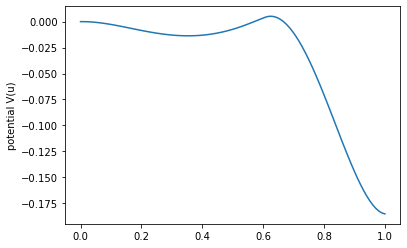

In [19]:
u = np.linspace(0,1,100)

reaction = point_wise_model.predict(u).reshape(u.shape[0])*dt*(-u)*(1-u)

reaction_integral = np.zeros_like(reaction)

for i in range(100):
    reaction_integral[i] = np.sum(reaction[0:i])
    
plt.plot(u,reaction_integral)

plt.ylabel('potential V(u)')

Text(0, 0.5, 'potential V(u)')

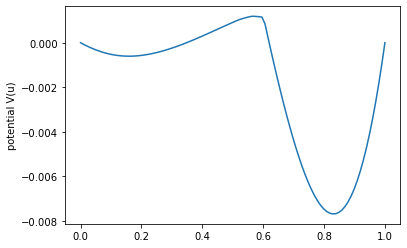

In [20]:
reaction = point_wise_model.predict(u).reshape(u.shape[0])*dt*(-u)*(1-u)
plt.plot(u,reaction)

plt.ylabel('potential V(u)')

In [21]:
def pde_pred(model,u):
    u1 = np.array(1).reshape((1,1))
    udt = model.predict([u,u1])
    return udt
    
def pred(model,u,n):
    for i in range(n):
        u = pde_pred(model,u)
    return u

In [22]:
def plot_images(*images):
    fig, ax = plt.subplots(1, len(images), figsize=(3*len(images), 4))
    for a, i in zip(ax, images):
        im = a.imshow(np.squeeze(i), vmin=0, vmax=1)
        fig.colorbar(im, ax=a)
        a.set_xlim([0, 180])
        a.set_ylim([600, 0])

In [23]:
def plot_images_series(ncuts):
    cut = img_example[ncuts,0,:,:].reshape((1,600,180,1))/255.0

    plot_images(cut,img_example[ncuts,20,:,:]/255.0,img_example[ncuts,40,:,:]/255.0,img_example[ncuts,60,:,:]/255.0,img_example[ncuts,80,:,:]/255.0,img_example[ncuts,100,:,:]/255.0,img_example[ncuts,120,:,:]/255.0)        
    
    print('')
    plot_images(cut,pred(model,cut,20),pred(model,cut,40),pred(model,cut,60),pred(model,cut,80),pred(model,cut,100),pred(model,cut,120))
    
    print('Ground truth (first row) & prediction (second row).')
    


Ground truth (first row) & prediction (second row).


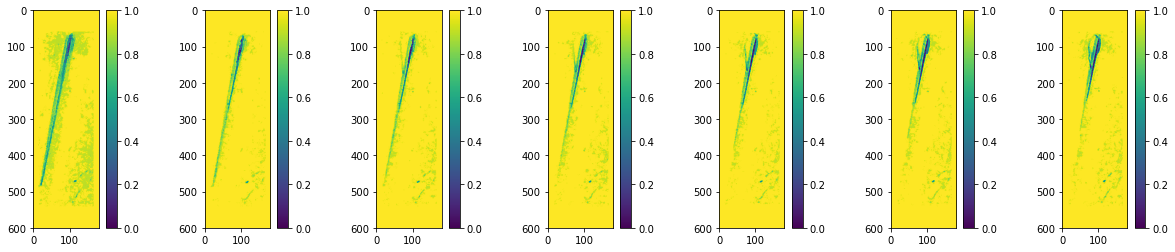

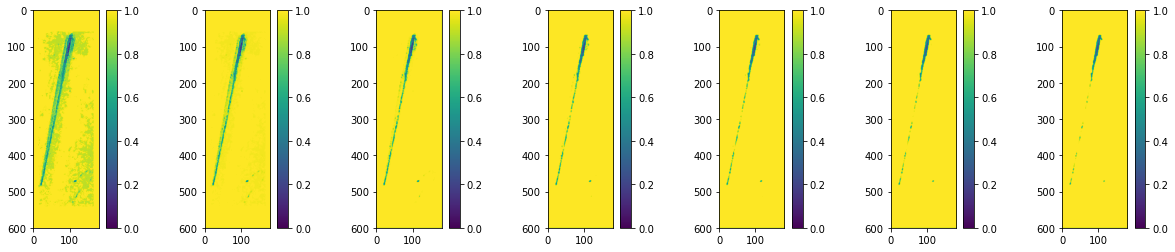

In [24]:
plot_images_series(0)


Ground truth (first row) & prediction (second row).


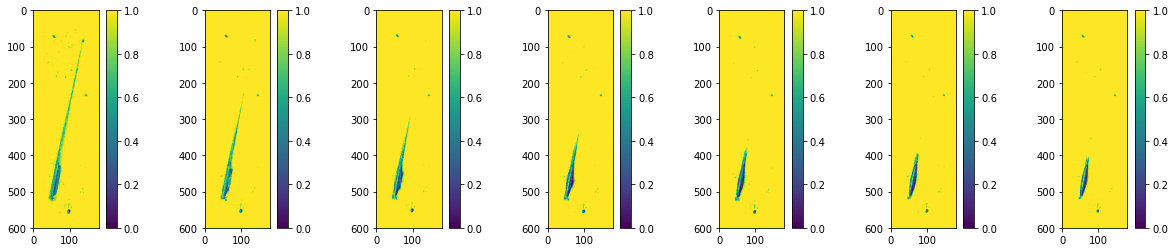

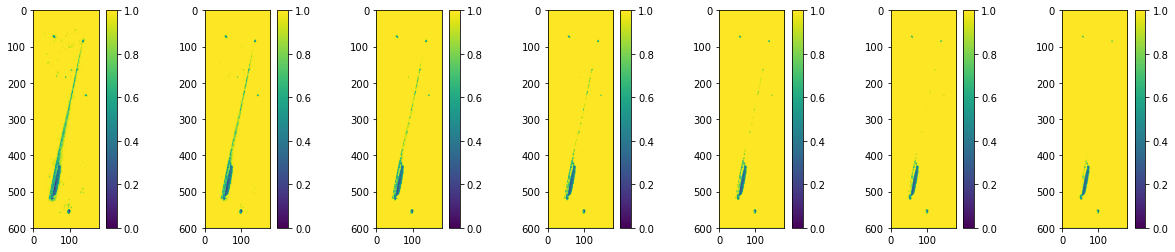

In [25]:
plot_images_series(1)


Ground truth (first row) & prediction (second row).


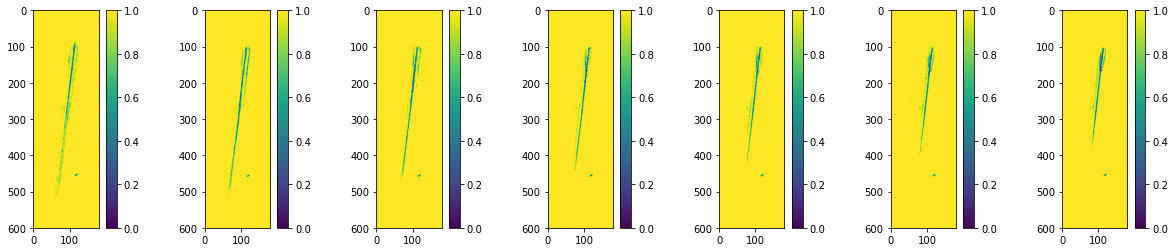

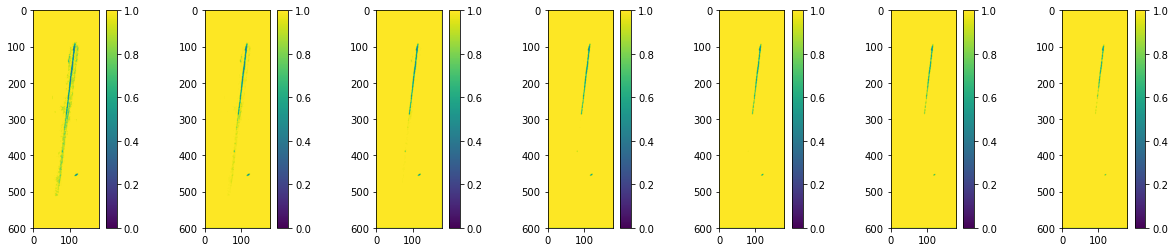

In [26]:
plot_images_series(2)


Ground truth (first row) & prediction (second row).


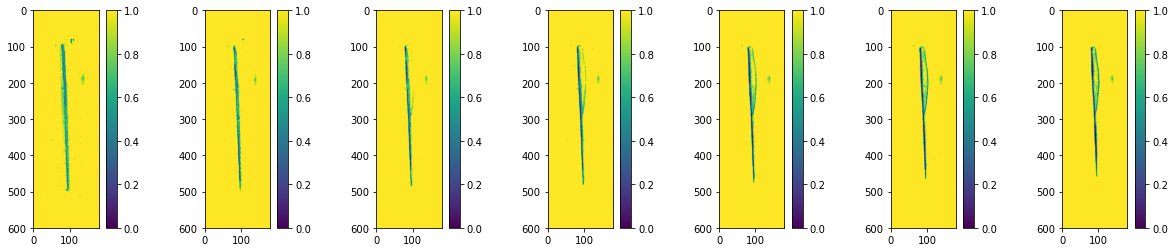

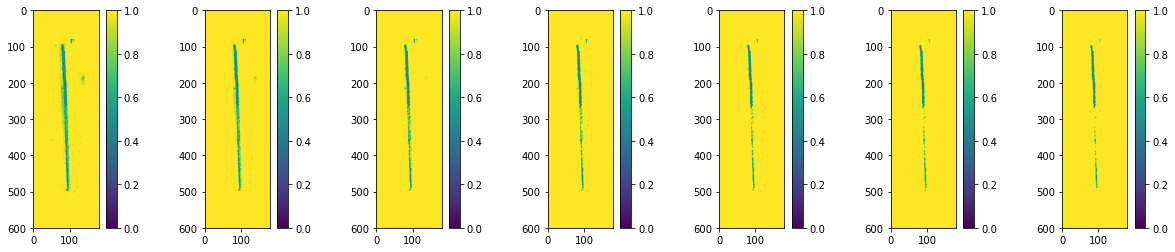

In [27]:
plot_images_series(4)


Ground truth (first row) & prediction (second row).


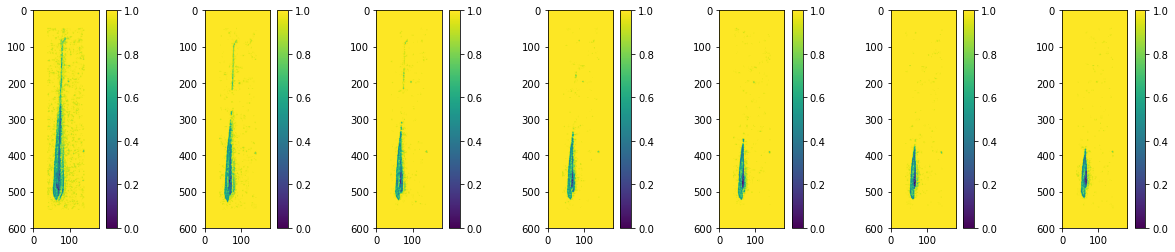

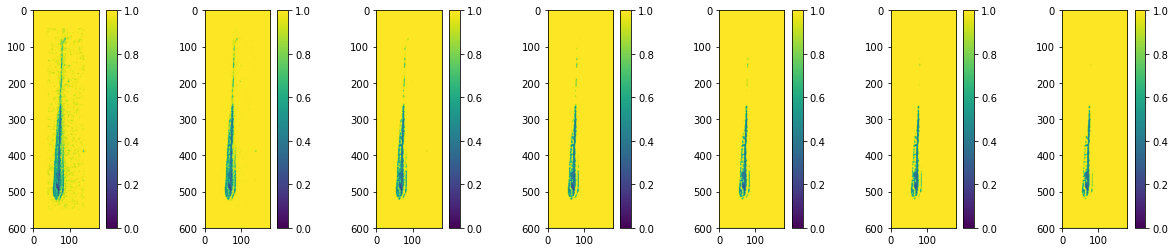

In [28]:
plot_images_series(5)


Ground truth (first row) & prediction (second row).


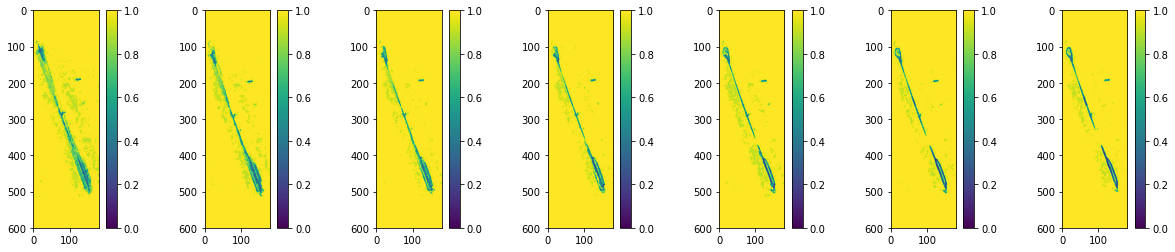

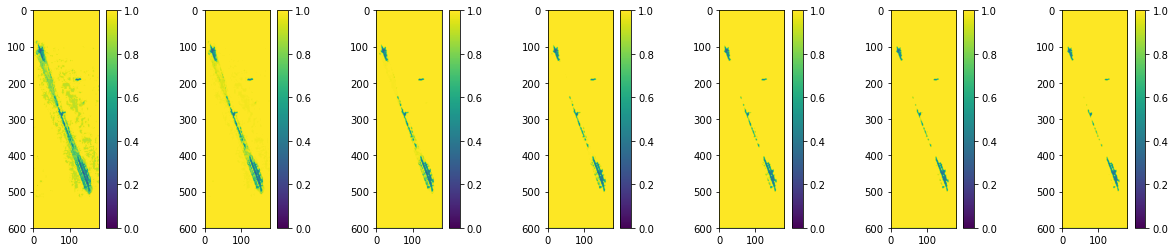

In [29]:
plot_images_series(6)


Ground truth (first row) & prediction (second row).


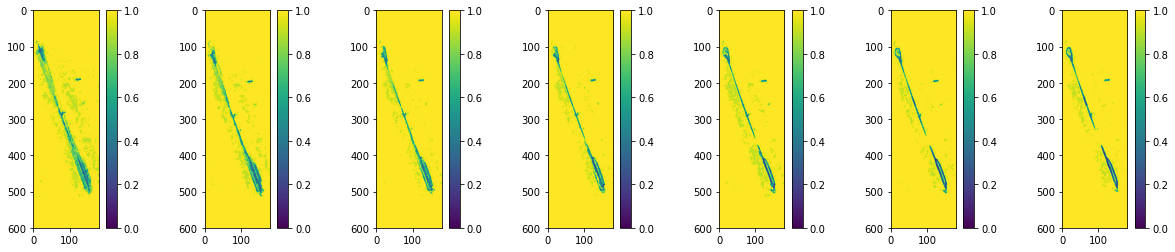

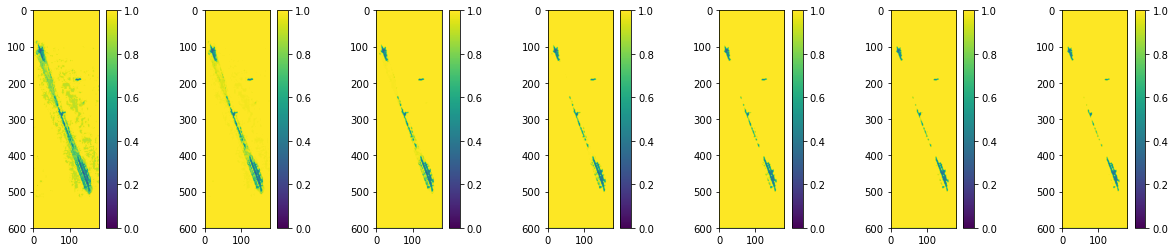

In [30]:
plot_images_series(7)